# 第9章 边缘检测

- 图像灰度或色彩的显著变化，对感知和理解图像非常重要，通常把这些灰度或色彩显著变化的点称为边缘点，邻接连通的边缘点构成的线段，称为边缘（edge）；位于不同物体区域之间的边缘称为边界（boundary），由围绕一个物体区域的边界所形成的闭合通路称为轮廓（contour）。边缘和轮廓对于人类视觉感知非常重要，如漫画或素描，寥寥数笔线条就可以清楚地描绘一个物体或者场景。图像锐化的实质就是检测并增强边缘，以提高图像中物体的可识别度。
- 物体检测与识别（object detection and recognition）是图像分析和计算机视觉的研究重点。由于边缘是物体与背景之间、不同物体之间的边界，这意味着，如果能够准确地识别图像中的边缘，就可以定位并测量物体区域的面积、轮廓周长和形状等基本属性，进而对图像中的物体进行识别和分类。因此，边缘检测（edge detection）是图像分析必不可少的工具。

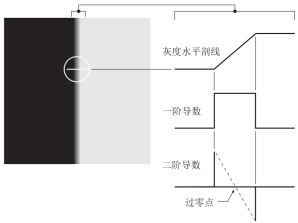

In [1]:
#导入本章示例用到的包,使用本文档中示例,先运行一次本段代码
#-*- coding: utf-8 -*-
import numpy as np
import cv2 as cv
from skimage import io,util,filters,feature,transform,draw,color,morphology
from scipy import ndimage
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['STSong'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False   #用来正常显示负号
%matplotlib inline

## 9.1 基于梯度的边缘检测

### 示例：图像梯度的计算

#### 采用OpenCV 函数实现
- dx, dy=cv.spatialGradient(src[, dx[, dy[, ksize[, borderType]]]])
    - Calculates the first order image derivative in both x and y using a Sobel operator.
- dst=cv.Sobel(src, ddepth, dx, dy[, dst[, ksize[, scale[, delta[, borderType]]]]])
    - Calculates the first, second, third, or mixed image derivatives using an extended Sobel operator.
- dst=cv.Scharr(src, ddepth, dx, dy[, dst[, scale[, delta[, borderType]]]])
    - Calculates the first x- or y- image derivative using Scharr operator.
- angle=cv.phase(x, y[, angle[, angleInDegrees]])
    - Calculates the rotation angle of 2D vectors.
- magnitude, angle=cv.cartToPolar(x, y[, magnitude[, angle[, angleInDegrees]]])
    - Calculates the magnitude and angle of 2D vectors.

In [ ]:
#OpenCV: Sobel,Scharr算子图像梯度的计算示例

#读入一幅灰度图像
img = cv.imread('./imagedata/cameraman.tif',0)

#计算图像水平方向x, 垂直方向y的梯度分量
dx, dy= cv.spatialGradient(img)
#梯度向量的幅值和方向角
magnitude, angle=cv.cartToPolar(np.float32(dx), np.float32(dy))
#用梯度幅度图像中最大值的0.2倍为阈值进行阈值分割
sobel_edgebw = magnitude > 0.20 * np.max(magnitude)

#采用标准差为2的高斯滤波器平滑原图像
img_smooth = cv.GaussianBlur(img,ksize=(0,0),sigmaX=2,sigmaY=2)
#采用Scharr算子计算梯度向量
scharr_x = cv.Scharr(img_smooth,ddepth=cv.CV_64F,dx=1,dy=0)
scharr_y = cv.Scharr(img_smooth,ddepth=cv.CV_64F,dx=0,dy=1)
#Scharr梯度向量幅值
scharr_edge = cv.sqrt(scharr_x**2 + scharr_y**2)
#用梯度幅度图像中最大值的0.2倍为阈值进行阈值分割
scharr_edgebw = scharr_edge > 0.20 * np.max(scharr_edge)

#显示结果
plt.figure(figsize=(12,12))
plt.gray()

#原图像
plt.subplot(3,3,1), plt.imshow(img)
plt.title('Original image') 
plt.axis('off')
# Sobel水平方向梯度分量绝对值,垂直边缘
plt.subplot(3,3,2), plt.imshow(np.abs(dx))
plt.title('Sobel vertical edges')
plt.axis('off')
# Sobel垂直方向梯度分量绝对值,水平边缘
plt.subplot(3,3,3), plt.imshow(np.abs(dy))
plt.title('Sobel horizontal edges')
plt.axis('off')
# Sobel梯度向量的方向角
plt.subplot(3,3,4), plt.imshow(angle)
plt.title('Sobel gradient angles')
plt.axis('off')
# Sobel梯度向量的幅值
plt.subplot(3,3,5), plt.imshow(magnitude)
plt.title('Sobel edges')
plt.axis('off')
# Sobel边缘检测,阈值分割
plt.subplot(3,3,6), plt.imshow(sobel_edgebw)
plt.title('Sobel edges thresholded')
plt.axis('off')

# 高斯平滑滤波图像
plt.subplot(3,3,7), plt.imshow(img_smooth)
plt.title('Smoothed image')
plt.axis('off')
# 平滑图像Scharr梯度向量的幅值
plt.subplot(3,3,8), plt.imshow(scharr_edge)
plt.title('Smoothed image, Scharr edges')
plt.axis('off')
# 平滑图像Scharr边缘检测,阈值分割
plt.subplot(3,3,9), plt.imshow(scharr_edgebw)
plt.title('Smoothed image, Scharr edges thresholded')
plt.axis('off')

plt.show()

#### 采用Scikit-image 函数实现
- Edge operators
- https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html#sphx-glr-auto-examples-edges-plot-edge-filter-py
- Find the edge magnitude using Roberts' cross operator
- Adapting gray-scale filters to RGB images
- https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_adapt_rgb.html#sphx-glr-auto-examples-color-exposure-plot-adapt-rgb-py

In [ ]:
#Scikit-image: Sobel算子图像梯度的计算示例

#读入一幅灰度图像
img = io.imread('./imagedata/cameraman.tif')

#计算水平方向梯度分量,相当于垂直边缘
dx = filters.sobel(img, axis=1)


#计算垂直方向梯度分量,相当于水平边缘
dy = filters.sobel(img, axis=0)

#计算梯度向量的幅值
edge_sobel = np.sqrt(dx**2 + dy**2)
#用梯度幅度图像中最大值的0.2倍为阈值进行阈值分割
edge_sobel_bw = edge_sobel > 0.20 * np.max(edge_sobel)
#计算梯度向量的方向角
angle_sobel =np.arctan2(dy,dx)

#采用标准差为2的高斯滤波器平滑原图像
img_smooth = filters.gaussian(img, sigma=2)
#计算梯度幅值
edge_sobel_smooth = filters.sobel(img_smooth)
#用梯度幅度图像中最大值的0.2倍为阈值进行阈值分割
edge_sobel_smooth_bw = edge_sobel_smooth > 0.20 * np.max(edge_sobel_smooth)

#显示结果,为便于观察,将边缘图像反色显示
plt.figure(figsize=(12,12))
plt.gray()

#原图像
plt.subplot(3,3,1), plt.imshow(img)
plt.title('Original image') 
plt.axis('off')
# Sobel水平方向梯度分量绝对值,垂直边缘
plt.subplot(3,3,2), plt.imshow(1- np.abs(dx))
plt.title('Sobel vertical edges')
plt.axis('off')
# Sobel垂直方向梯度分量绝对值,水平边缘
plt.subplot(3,3,3), plt.imshow(1- np.abs(dy))
plt.title('Sobel horizontal edges')
plt.axis('off')

# Sobel梯度向量的方向角
plt.subplot(3,3,4), plt.imshow(angle_sobel)
plt.title('Sobel gradient angles')
plt.axis('off')
# Sobel梯度向量的幅值
plt.subplot(3,3,5), plt.imshow(1- edge_sobel)
plt.title('Sobel edges')
plt.axis('off')
# Sobel边缘检测,阈值分割
plt.subplot(3,3,6), plt.imshow(1- edge_sobel_bw)
plt.title('Sobel edges thresholded')
plt.axis('off')

# 高斯平滑滤波图像
plt.subplot(3,3,7), plt.imshow(img_smooth)
plt.title('Smoothed image')
plt.axis('off')
# 平滑图像Sobel梯度向量的幅值
plt.subplot(3,3,8), plt.imshow(1- edge_sobel_smooth)
plt.title('Smoothed image, Sobel edges')
plt.axis('off')
# 平滑图像Sobel边缘检测,阈值分割
plt.subplot(3,3,9), plt.imshow(1- edge_sobel_smooth_bw)
plt.title('Smoothed image, Sobel edges thresholded')
plt.axis('off')

plt.show()

### 示例：Roberts交叉、Prewitt、Sobel、Scharr梯度算子边缘检测对比

In [ ]:
#Scikit-image:几种常用梯度算子图像边缘强度比较

#读入一幅灰度图像
img = io.imread('./imagedata/cameraman.tif')

#Scikit-image梯度计算函数先将输入图像数据类型转换为[0,1]之间取值的浮点型
# Roberts交叉梯度算子
edge_roberts = filters.roberts(img)
# Prewitt梯度算子
edge_prewitt = filters.prewitt(img)
# Sobel梯度算子
edge_sobel = filters.sobel(img)
# Scharr梯度算子
edge_scharr = filters.scharr(img)
edge_scharr_bw = edge_scharr > 0.20 * np.max(edge_scharr)

#显示结果,为便于观察,将边缘图像反色显示
plt.figure(figsize=(12,8))
plt.gray()

#原图像
plt.subplot(2,3,1); plt.imshow(img)
plt.title('Original image') 
plt.axis('off')
# Roberts边缘检测
plt.subplot(2,3,2); plt.imshow(1-edge_roberts)
plt.title('Roberts edge detection')
plt.axis('off')
# Prewitt边缘检测
plt.subplot(2,3,3); plt.imshow(1-edge_prewitt)
plt.title('Prewitt edge detection')
plt.axis('off')
# Sobel边缘检测
plt.subplot(2,3,4); plt.imshow(1-edge_sobel)
plt.title('Sobel edge detection')
plt.axis('off')
# Scharr边缘检测
plt.subplot(2,3,5); plt.imshow(1-edge_scharr)
plt.title('Scharr edge detection')
plt.axis('off')
# Scharr边缘检测,阈值分割
plt.subplot(2,3,6); plt.imshow(1-edge_scharr_bw)
plt.title('Scharr edge thresholded')
plt.axis('off')

plt.show()

## 9.2 基于二阶导数的边缘检测
### 9.2.1 拉普拉斯算子Laplacian operator
### 9.2.2 高斯拉普拉斯算子LoG(Laplacian of Gaussian)

- dst=cv.Laplacian(src, ddepth[, dst[, ksize[, scale[, delta[, borderType]]]]])
    - Calculates the Laplacian of an image.


### 示例：采用高斯拉普拉斯(LoG)算子检测图像边缘

In [ ]:
#采用Laplace算子和LoG算子检测图像边缘

#读入一幅灰度图像
img = cv.imread('./imagedata/cameraman.tif',0) 

#OpenCV:Laplace算子
edge_laplace1 = cv.Laplacian(img,ddepth=cv.CV_64F)
#Scikit-image:Laplace算子
edge_laplace2 = filters.laplace(img) 

#SciPy:LoG算子
edge_log = ndimage.gaussian_laplace(np.float32(img), sigma=2)
#对edge_log的绝对值进行阈值分割
edge_log_bw = np.abs(edge_log)>0.1*np.max(np.abs(edge_log))
                           
#显示结果
plt.figure(figsize=(18,9))
#灰度图像显示方式
plt.gray() 
                                          
#原图像
plt.subplot(1,5,1); plt.imshow(img)
plt.title('Original image') 
plt.axis('off')
# Laplace边缘
plt.subplot(1,5,2); plt.imshow(edge_laplace1)
plt.title('Laplace edge by OpenCV')
plt.axis('off')
# Laplace边缘
plt.subplot(1,5,3); plt.imshow(edge_laplace2)
plt.title('Laplace edge by Scikit-image')
plt.axis('off')
# LoG边缘
plt.subplot(1,5,4); plt.imshow(edge_log)
plt.title('LoG edge')
plt.axis('off')
# 对LoG绝对值二值化边缘
plt.subplot(1,5,5); plt.imshow(edge_log_bw)
plt.title('LoG edge thresholded')
plt.axis('off')

plt.tight_layout()
plt.show()

## 9.3 Canny边缘检测算子

- 1986年John F. Canny提出了一个多级边缘检测算法，它使用一系列不同尺寸的高斯滤波器对图像进行平滑滤波，然后从这些平滑后的图像中检测边缘，并将不同尺度的边缘融合起来形成最终的边缘图像。Canny为找到最优的边缘检测算法，定义了三个主要准则：
    - 低错误率。非边缘点被错标为边缘点的数量最少。
    - 定位精确。标为边缘的点应尽可能靠近真实边缘的中心位置。
    - 单像素边缘宽度。在每个边缘点位置仅给出单个像素。

- edges =cv.Canny(image, threshold1, threshold2[, edges[, apertureSize[, L2gradient]]])
    - Finds edges in an image using the Canny algorithm
- skimage.feature.canny(image, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False)
    - Edge filter an image using the Canny algorithm.

### 示例：采用Canny算子检测图像边缘

In [ ]:
#采用Canny算子检测图像边缘

#读入一幅灰度图像
img = cv.imread('./imagedata/cameraman.tif',0)

#OpenCV: #Canny算子
edge_canny1 = cv.Canny(img,threshold1=50,threshold2=200)

#Scikit-image: Canny算子,采用缺省参数
edge_canny2 = feature.canny(img)

#标准差sigma=1,指定高低阈值(边缘幅值的百分位数)
edge_canny3 = feature.canny(img,sigma=1,
                            low_threshold=0.05,
                            high_threshold=0.95,
                            use_quantiles=True)
#增大高斯平滑滤波器的标准差sigma=2
edge_canny4 = feature.canny(img,sigma=2)

#显示结果
plt.figure(figsize=(12,8))
#灰度图像显示方式
plt.gray() 
                                          
#原图像
plt.subplot(2,3,1), plt.imshow(img)
plt.title('Original image') 
plt.axis('off')
# OpenCV:Canny边缘
plt.subplot(2,3,2), plt.imshow( edge_canny1)
plt.title('Canny edge by openCV')
plt.axis('off')
# Scikit-image:Canny边缘,默认参数
plt.subplot(2,3,4), plt.imshow( edge_canny2)
plt.title('Canny edge,default parameters')
plt.axis('off')
#Scikit-image:Canny边缘,标准差sigma=1,指定高低阈值
plt.subplot(2,3,5), plt.imshow(edge_canny3)
plt.title('Canny edge,given low_threshold and high_threshold')
plt.axis('off')
# Scikit-image:Canny边缘,标准差sigma=2
plt.subplot(2,3,6), plt.imshow(edge_canny4)
plt.title('Canny edge,sigma=2')
plt.axis('off')

plt.tight_layout()
plt.show()

## 9.4 Hough变换

- Hough变换（Hough Transform，霍夫变换）就是从边缘图中寻找直线、圆和椭圆等几何曲线边缘结构的全局性方法。Hough变换由Paul Hough于1959年提出，1962年被授予美国专利，经Richard Duda、Peter Hart和Ballard改进推广后得到广泛应用。起初Hough变换主要用来检测图像中的直线，后来逐渐扩展到识别圆、椭圆等几何曲线。
- Hough变换是一种基于“投票表决”的几何曲线形状识别技术，它根据局部度量来计算全局描述参数，因而对于区域边界被噪声干扰或被其他目标遮盖而引起的边界间断情况，具有很好的容错性和鲁棒性。

### 示例：用Hough变换检测直线

### 使用OpenCV函数
- lines = cv.HoughLines(image, rho, theta, threshold[, lines[, srn[, stn[, min_theta[, max_theta]]]]])
    - Finds lines in a binary image using the standard Hough transform.
- lines = cv.HoughLinesP(image, rho, theta, threshold[, lines[, minLineLength[, maxLineGap]]])
    - Finds line segments in a binary image using the probabilistic Hough transform.

In [ ]:
#OpenCV标准Hough变换直线检测示例

#构建一幅二值图像用于测试
img = np.zeros((100, 150), dtype=np.uint8)

img = cv.line(img,(65,0),(65,99),255,1)
img = cv.line(img,(0,30),(150,30),255,1)
img = cv.line(img,(130,60),(10,80),255,1) 
img = cv.line(img,(20,40),(100,80),255,1) 
img = cv.line(img,(100,5),(135,95),255,1)
#标准Hough变换
lines = cv.HoughLines(img,rho=1,theta=np.pi/90,threshold=50)

#显示检测到的直线参数
print('距离  rho:',lines[:,0,0])
print('角度theta:',np.round(np.rad2deg(lines[:,0,1])))

#将灰度图像转换为RGB颜色通道图像，用黄色绘出检测到的每根直线
imgresult = cv.cvtColor(img, cv.COLOR_GRAY2RGB)

#设定检测到的直线x轴坐标范围(数组列下标)
xp = np.arange(0,img.shape[1])
#根据参数rho,theta计算每条直线对应的y轴坐标值(数组行下标)
for line in lines:
    rho,theta = line[0] 
    if theta==0: #画垂直直线        
        #确定在图像范围内的直线端点坐标 
        x1 = np.int32(rho);  y1 = 0
        x2 =  np.int32(rho); y2 = img.shape[0]-1
    else:
        yp =np.int32((rho - xp * np.cos(theta)) / np.sin(theta))
        #确定在图像范围内的直线端点坐标
        yidx = np.logical_and(yp>=0, yp<img.shape[0])
        x1 = xp[yidx][0];  y1 = yp[yidx][0]
        x2 = xp[yidx][-1]; y2 = yp[yidx][-1]
    #画线
    imgresult = cv.line(imgresult,(x1,y1),(x2,y2),(255,255,0),1) 
    
#显示结果
plt.figure(figsize=(15,5))
plt.gray()

#原图像
plt.subplot(1,2,1); plt.imshow(img)
plt.title('Input image')
#叠加显示检测到的直线
plt.subplot(1,2,2); plt.imshow(imgresult)
plt.title('Detected lines')  

plt.show()

In [ ]:
lines.shape
#a1 = np.squeeze(lines)

In [ ]:
# Scikit-image: 标准Hough变换直线检测示例
#构建一幅二值图像用于测试
img = np.zeros((100, 150), dtype=np.uint8)
img[30, :] = 255
img[:, 65] = 255
rr, cc = draw.line(60, 130, 80, 10)
img[rr, cc] = 255
rr, cc = draw.line(r0=40, c0=20, r1=80, c1=100)
img[rr, cc] = 255
rr, cc = draw.line(r0=5, c0=100, r1=95, c1=135 )
img[rr, cc] = 255


#角度间隔为0.5度Set a precision of 0.5 degree.
angles_axis = np.deg2rad(np.arange(-90, 91, 0.5))
#标准Hough变换
hspace, theta, rho_dist = transform.hough_line(img,theta=angles_axis)
#获取Hough空间hspace中的峰值及对应直线参数
accum,angles,dists= transform.hough_line_peaks(hspace, theta,rho_dist)

#显示检测到的直线参数
print('边缘点数:',accum)
print('角度theta:',np.rad2deg(angles))
print('距离  rho:',np.round(dists))

#将二值测试图像转换为RGB颜色通道图像
#将Hough变换检测得到的直线以黄色叠加到图像中
img_result = color.gray2rgb(img)

#设定检测到的直线x轴坐标范围(数组列下标)
xp = np.arange(0,img.shape[1])
#根据参数rho,theta计算每条直线对应的y轴坐标值(数组行下标)
for i in range(angles.shape[0]):    
    if angles[i] == 0: #垂直线
        #确定在图像范围内的直线端点坐标 
        x1 = np.int32(dists[i]);  y1 = 0
        x2 =  np.int32(dists[i]); y2 = img.shape[0]-1
    else:
        yp =np.int32((dists[i] - xp * np.cos(angles[i])) / np.sin(angles[i]))
        #确定在图像范围内的直线端点坐标
        yidx = np.logical_and(yp>=0, yp<img.shape[0])
        x1 = xp[yidx][0];  y1 = yp[yidx][0]
        x2 = xp[yidx][-1]; y2 = yp[yidx][-1]
    #画线
    img_result = cv.line(img_result,(x1,y1),(x2,y2),(255,255,0),1)

#显示结果
plt.figure(figsize=(15,5))

#输入图像
plt.subplot(1,3,1); plt.imshow(img,cmap='gray')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Input image') 
#显示累加器数组(Hough空间)计数状态
plt.subplot(1,3,2);
plt.imshow(np.log(1+hspace),cmap='gray',extent=[np.rad2deg(theta[0]), np.rad2deg(theta[-1]), rho_dist[-1], rho_dist[0]])
plt.title('Hough transform')
#plt.xlabel('Angles (degrees)')
#plt.ylabel('Distance (pixels)')
plt.xlabel('角度(单位：度)',fontsize=15)
plt.ylabel('距离(单位：像素)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.axis('image')
#叠加显示检测到的直线
plt.subplot(1,3,3); plt.imshow(img_result)
plt.title('Detected lines')    
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

#plt.tight_layout()
plt.show()

## 概率霍夫变换 Probabilistic Hough Transform

In [ ]:
#Scikit-image: 概率Hough变换(Probabilistic Hough Transform)直线检测示例
#构建一幅二值图像用于测试
img = np.zeros((100, 150), dtype=np.uint8)
img[30, :] = 255
img[:, 65] = 255
rr, cc = draw.line(60, 130, 80, 10)
img[rr, cc] = 255
rr, cc = draw.line(r0=40, c0=20, r1=80, c1=100)
img[rr, cc] = 255
rr, cc = draw.line(r0=5, c0=100, r1=95, c1=135 )
img[rr, cc] = 255

#概率Hough变换
lines = transform.probabilistic_hough_line(img,threshold=10,line_length=60,line_gap=3)
#显示检测到的线段端点坐标
print('检测到的线段端点坐标:',lines)

#将二值测试图像转换为RGB颜色通道图像
img_result2 = color.gray2rgb(img)

#用随机颜色绘出检测到的每根直线
for line in lines:
    #得到检出的线段端点坐标
    p0, p1 = line
    #产生随机颜色
    r = np.random.randint(125, 255)
    g = np.random.randint(125, 255)
    b = np.random.randint(125, 255)
    #画线
    img_result2 = cv.line(img_result2, p0, p1,(b, g, r), 1)

#显示结果
plt.figure(figsize=(15,5))
#输入图像
plt.subplot(1,2,1); plt.imshow(img,cmap='gray')
plt.title('Input image') 

#叠加显示检测到的直线
plt.subplot(1,2,2); plt.imshow(img_result2)
plt.title('Detected lines')  

#plt.tight_layout()
plt.show()

In [ ]:
#Scikit-image: Hough变换机械零件直线检测示例

#读入一幅灰度图像
img = io.imread('./imagedata/workpiece.png')

#高斯平滑滤波
img_smooth = ndimage.gaussian_filter(img, sigma=5)
#得到边缘图像
edges = feature.canny(img_smooth,sigma=2)#, low_threshold=0.05, high_threshold=0.95,use_quantiles=True)

#标准Hough变换
#角度间隔为0.5度
angles_axis = np.deg2rad(np.arange(-90, 91, 0.5))
hspace, theta, rho_dist = transform.hough_line(edges,theta=angles_axis)
#获取Hough空间hspace中的峰值及对应直线参数
accum,angles,dists= transform.hough_line_peaks(hspace, theta,rho_dist,
                                               threshold = 0.2 * np.max(hspace))

#显示检测到的直线参数
print('标准Hough变换_边缘点数:',accum)
print('标准Hough变换_角度theta:',np.rad2deg(angles))
print('标准Hough变换_距离rho:',np.round(dists))

#将灰度图像转换为RGB颜色通道图像，用随机颜色绘出检测到的每根直线
img_result1 = color.gray2rgb(img)

#设定检测到的直线x轴坐标范围(数组列下标)
xp = np.arange(0,img.shape[1])
#根据参数rho,theta计算每条直线对应的y轴坐标值(数组行下标)
for i in range(angles.shape[0]):    
    if angles[i] == 0: #垂直线
        #确定在图像范围内的直线端点坐标 
        x1 = np.int32(dists[i]);  y1 = 0
        x2 = np.int32(dists[i]);  y2 = img.shape[0]-1
    else:
        yp =np.int32((dists[i] - xp * np.cos(angles[i])) / np.sin(angles[i]))
        #确定在图像范围内的直线端点坐标
        yidx = np.logical_and(yp>=0, yp<img.shape[0])
        x1 = xp[yidx][0];  y1 = yp[yidx][0]
        x2 = xp[yidx][-1]; y2 = yp[yidx][-1]
    #产生随机颜色
    r = np.random.randint(50, 255)
    g = np.random.randint(50, 255)
    b = np.random.randint(50, 255)
    #画线
    img_result1 = cv.line(img_result1,(x1,y1),(x2,y2),(r,g,b),3)

#概率Hough变换
lines = transform.probabilistic_hough_line(edges,threshold=10,line_length=50,line_gap=20)
#显示检测到的直线段数
print('\n概率Hough变换检测到的直线段数:',len(lines))

#将灰度图像转换为RGB颜色通道图像
img_result2 = color.gray2rgb(img)

#用随机颜色绘出检测到的每根直线
for line in lines:
    #得到检出的线段端点坐标
    p0, p1 = line
    #产生随机颜色
    r = np.random.randint(50, 255)
    g = np.random.randint(50, 255)
    b = np.random.randint(50, 255)
    #画线
    img_result2 = cv.line(img_result2, p0, p1,(b, g, r), 3)

#显示结果
plt.figure(figsize=(15,5))
#输入图像
plt.subplot(1,4,1); plt.imshow(img,cmap='gray')
plt.title('Input image');plt.axis('off') 
#边缘图像
plt.subplot(1,4,2); plt.imshow(edges, cmap='gray')
plt.title('Canny edges');plt.axis('off')
#叠加显示标准Houth变换检测到的直线
plt.subplot(1,4,3); plt.imshow(img_result1)
plt.title('Detected lines by SHT');plt.axis('off')      
#叠加显示概率Hough变换检测到的直线
plt.subplot(1,4,4); plt.imshow(img_result2)
plt.title('Detected lines by PPHT');plt.axis('off') 

plt.tight_layout()
plt.show()

In [11]:
#io.imsave('workpiece_PPHT.png',img_result2)

## 9.4.3 用Hough变换检测圆

### 示例：检测图像中的圆

#### OpenCV 圆检测Circle detection
- circles=cv.HoughCircles(image, method, dp, minDist[, circles[, param1[, param2[, minRadius[, maxRadius]]]]])
    - Finds circles in a grayscale image using the Hough transform.

In [ ]:
# OpenCV: Hough变换圆检测示例

#读入一幅灰度图像
img = cv.imread('./imagedata/oak_barrels.png',0)

#对图像进行双边滤波
img2 = cv.bilateralFilter(img,9,75,75)
#或对图像进行高斯滤波
#img2 = cv.medianBlur(img,7)

#Hough圆变换，如果maxRadius=0, 则使用图像的最大尺寸
circles = cv.HoughCircles(img2,cv.HOUGH_GRADIENT,1,30, \
                          param1=100,param2=90,minRadius=20,maxRadius=0)

#将灰度图像转换为RGB颜色通道图像
imgrgb = cv.cvtColor(img2,cv.COLOR_GRAY2RGB)
#用绿色绘出检测到的每个圆环,红色画圆心
circles = np.uint16(np.around(circles))
for i in circles[0,:]:
    #画圆环draw the outer circle
    imgrgb = cv.circle(imgrgb,(i[0],i[1]),i[2],(0,255,0),2)
    #画圆心draw the outer circle
    imgrgb = cv.circle(imgrgb,(i[0],i[1]),7,(255,0,0),-1)
    
#显示结果
plt.figure(figsize=(15,8))
#原图像
plt.subplot(1,2,1); plt.imshow(img,cmap='gray')
plt.title('Input image')
plt.axis('off')
#叠加显示Houth变换检测到的圆及圆心
plt.subplot(1,2,2); plt.imshow(imgrgb)
plt.title('Detected circles')
plt.axis('off')

plt.show()

In [ ]:
# Scikit-image: Hough变换圆检测示例
#读入一幅灰度图像
img = io.imread('./imagedata/oak_barrels.png')
#对图像进行双边滤波
img_smooth = filters.rank.mean_bilateral(img, morphology.disk(20), s0=20,s1=20)
#或对图像进行高斯滤波
#img_smooth = ndimage.gaussian_filter(img, sigma=2)
#边缘检测
edges = feature.canny(img_smooth,sigma=1.5,
                      low_threshold=0.05,
                      high_threshold=0.95,
                      use_quantiles=True)

#设定要检测圆的半径范围,半径分辨率为2个像素
hough_radii = np.arange(50, 200, 2)
#Hough圆变换
Hspace = transform.hough_circle(edges, hough_radii)
#Hough空间峰值检测
accums, cx, cy, radii = transform.hough_circle_peaks(Hspace, hough_radii, 
                                           min_xdistance=20, 
                                           min_ydistance=20,
                                           threshold=0.5 * np.max(Hspace),
                                           total_num_peaks=20,
                                           normalize=True)

#将灰度图像转换为RGB颜色通道图像
img_circles = color.gray2rgb(img)
#用绿色绘出检测到的每个圆环,红色画圆心
for center_x, center_y, radi in zip(cx, cy, radii):
    #画圆环draw the outer circle
    img_circles = cv.circle(img_circles,(center_x,center_y),radi,(0,255,0),thickness=2)
    #画圆心draw the center of the circle
    img_circles = cv.circle(img_circles,(center_x,center_y),3,(255,0,0),thickness=3)

#显示结果
plt.figure(figsize=(15,8))
#原图像
plt.subplot(1,3,1); plt.imshow(img_smooth,cmap='gray')
plt.title('Input image')
plt.axis('off')
#边缘图像
plt.subplot(1,3,2); plt.imshow(edges, cmap='gray')
plt.title('Canny edges')
plt.axis('off')
#叠加显示Houth变换检测到的圆及圆心
plt.subplot(1,3,3); plt.imshow(img_circles)
plt.title('Detected circles')
plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
#io.imsave('oak_barrels_circles.png',img_circles)

## 9.5 角点检测
- 角点检测（Corner detection）是图像处理和计算机视觉中常用的一种算子。
- 角点检测广泛应用于目标跟踪、目标识别、图像配准与匹配、三维重建、摄像机标定等计算机视觉领域。

### 示例：Scikit-image 角点检测Corner detection

In [ ]:
#Scikit-image 角点检测示例Corner detection

#读入一幅灰度图像
img = io.imread('./imagedata/chessboard.png')

#计算Harris角点响应图像
harris_res = feature.corner_harris(img)
#从Harris角点响应图像获取峰值点及其行列下标,即为角点
coords = feature.corner_peaks(harris_res, min_distance=5, threshold_rel=0.005)

#用红色圆环标出检测到角点
#将灰度图像转换为RGB颜色通道图像
img_corners = util.img_as_ubyte(color.gray2rgb(img))
for corner in coords:
    #画红色圆环
    img_corners = cv.circle(img_corners,(corner[1],corner[0]),12,(255,0,0),thickness=2)

#显示结果
plt.figure(figsize=(12,6))
#原图像
plt.subplot(1,2,1); plt.imshow(img,cmap='gray')
plt.title('Input image')
plt.axis('off')
#叠加显示Harris方法检测到的角点
plt.subplot(1,2,2); plt.imshow(img_corners)
plt.title('Detected corners using Harris')
plt.axis('off')

plt.tight_layout()
plt.show()

## OpenCV 角点检测Corner detection
- retval, corners =cv.findChessboardCorners(image, patternSize[, corners[, flags]])
    - Finds the positions of internal corners of the chessboard.
- corners = cv.cornerSubPix(image, corners, winSize, zeroZone, criteria)
    - Refines the corner locations.
- image = cv.drawChessboardCorners(	image, patternSize, corners, patternWasFound)
    - Renders the detected chessboard corners.
- dst=cv.cornerHarris(src, blockSize, ksize, k[, dst[, borderType]])
    - Harris corner detector.

In [ ]:
#OpenCV: 棋盘格角点检测detects chessboard corners

#读入一幅灰度图像
img_gray = cv.imread('./imagedata/chessboard.png', 0)

#设定角点细化停止准则termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

#角点检测Find the chess board corners
ret, corners = cv.findChessboardCorners(img_gray, (9,6))

#将灰度图像转换为RGB颜色通道图像, 用于绘制检测到的角点
img_corners = cv.cvtColor(img_gray,cv.COLOR_GRAY2RGB)

#细化检测到角点
if ret == True:
    corners2 = cv.cornerSubPix(img_gray,corners,(5,5),(-1,-1),criteria)
    #绘制检测到的角点
    img_corners = cv.drawChessboardCorners(img_corners, (9,6), corners2,ret)

#显示结果
plt.figure(figsize=(12,6))

#原图像
plt.subplot(1,2,1); plt.imshow(img_gray,cmap='gray')
plt.title('Input image')
plt.axis('off')
#叠加显示检测到的角点
plt.subplot(1,2,2); plt.imshow(img_corners)
plt.title('Detected corners')
plt.axis('off')

plt.tight_layout()
plt.show()

# The end